In [1]:
import sys

sys.path.append("./../..")

from numba import jit
from numba.types import bool_, int_
import numpy as np
import matplotlib.pyplot as plt
from InternalLibrary.StatisticalFunctions import stat_corr_single, stat_s_redx
from scipy.optimize import curve_fit
from scipy.stats import moment

from tqdm import tqdm

from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import torch
import statistics

from InternalLibrary.StatisticalFunctions import *
from InternalLibrary.SimulatorPackage import Simulator_noGPU
from pathos.multiprocessing import ProcessingPool as ProcessPool
import pathos

In [2]:
class ParallelSimulator():
    def __init__(self, dt, DeltaT, TotalT, prior_lims, transient_time = 0, batch_size = 50, multi_round_mode = False, prior = None) -> None:
        self.sim_param = {'dt': dt, 'DeltaT': DeltaT, 'TotalT': TotalT, 'transient_time': transient_time}
        self.pool = ProcessPool(nodes=pathos.helpers.cpu_count())
        self.batch_size = batch_size
        self.prior_limits = prior_lims
        _ = self._dummy_run()
        self.multi_round_mode = multi_round_mode
        self.prior = prior
    
    def _dummy_run(self):
        Simulator_noGPU(dt = 1, DeltaT=1, TotalT = 2, theta = np.zeros(5).reshape(5,1,1), transient_time = 0)
    
    def _run_simulator(self, theta):
        return Simulator_noGPU(theta = theta, **self.sim_param)
    
    def _get_theta(self):
        if self.multi_round_mode:
            return self.prior.sample((self.batch_size,1)).T.reshape(5,self.batch_size,1).numpy()
        return get_theta_from_prior(self.prior_limits, self.batch_size)[0]
    
    def run(self,N):
        thetas = [self._get_theta() for _ in range(N)]
        s = self.pool.map(self._run_simulator, thetas)
        x = s[0][0]
        y = s[0][1]
        f = s[0][2]
        for i in np.arange(1,len(s)):
            x = np.concatenate([x, s[i][0]])
            y = np.concatenate([y, s[i][1]])
            f = np.concatenate([f, s[i][2]])
        t = thetas[0]
        for i in np.arange(1,len(thetas)):
            t = np.concatenate([t, thetas[i]],axis = 1)
        return x, y, f, t
    
    def same_theta_test(self,N,theta):
        thetas = [theta for _ in range(N)]
        s = self.pool.map(self._run_simulator, thetas)
        x = s[0][0]
        y = s[0][1]
        f = s[0][2]
        for i in np.arange(1,len(s)):
            x = np.concatenate([x, s[i][0]])
            y = np.concatenate([y, s[i][1]])
            f = np.concatenate([f, s[i][2]])
        return x, y, f
    
    
    
def prior_from_lims(prior_lims):
    NumberOfParameters = len(prior_lims)
    BoxLimits = np.zeros((2, NumberOfParameters))
    i = 0
    for item in prior_lims.items():
        BoxLimits[0, i] = item[1][0]
        BoxLimits[1, i] = item[1][1]
        i +=1
    BoxLimits = torch.tensor(BoxLimits)
    prior = utils.BoxUniform(low=BoxLimits[0], high=BoxLimits[1])
    return prior


# RSVP Compute Function Declaration
def ComputeRSVP(multiple_raw_x_traces,TotalT,transient = 0.5,DeltaT = 1/25_000, function = None):
    t = np.linspace(transient, TotalT, multiple_raw_x_traces[0].shape[0])
    autocorr = stat_corr_single(multiple_raw_x_traces[0,:], 1) .reshape(1,-1)
    n_sim = multiple_raw_x_traces.shape[0]
    if n_sim != 1:
        for i in np.arange(1,n_sim):
            autocorr = np.vstack((autocorr, stat_corr_single(multiple_raw_x_traces[i,:], DeltaT)))
    
    t_corr = TotalT/10
    _,_,RSVP = stat_s_redx(autocorr[0], t_corr, t)
    if n_sim != 1:
        for i in np.arange(1,n_sim):
            _,_,RSVP_ = stat_s_redx(autocorr[i], t_corr, t)
            RSVP = np.vstack((RSVP, RSVP_))
        
    if function is None:
        def function(x, a, b, c, d):
            return 1e4*(a*np.exp(-b*x) + c/x + d)
    
    t = t[(t>0)*(t<t_corr)]
    
    RSVP_fit = np.zeros((n_sim, 4))
    
    if n_sim != 1:
        for i in np.arange(n_sim):
            popt, _ = curve_fit(function, t, RSVP[i], p0 = [1.,1.,1.,1.],maxfev=1000000, bounds=([-10,0,0,0],[10,np.inf,np.inf,np.inf]))
            RSVP_fit[i] = popt
    else:
        popt, _ = curve_fit(function, t, RSVP, p0 = [1.,1.,1.,1.],maxfev=1000000)
        RSVP_fit[0] = popt
        
    return RSVP_fit, RSVP, t

# Single Round Inference

In [238]:
# Set up simulation Parameters
dt = 1e-6
DeltaT = 1/25_000
TotalT = 10.
transient = 0.5
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

batch_size = 50
N = pathos.helpers.cpu_count()
TotalSim = batch_size * N

print(f"Total Simulations: {TotalSim}")
print(f"Batch Size: {batch_size}")

Total Simulations: 400
Batch Size: 50


In [239]:
# Set up simulator and run it
Simulator = ParallelSimulator(dt, DeltaT, TotalT, prior_limits, transient_time = transient, batch_size = batch_size)
x, y, f, thetas = Simulator.run(N)

In [240]:
# Compute RSVP fit
RSVP_fit, RSVP, t = ComputeRSVP(x, TotalT, transient = transient)

In [241]:
# Set up prior and SBI and train
prior = prior_from_lims(prior_limits)
prior, num_parameters, prior_returns_numpy = process_prior(prior)
infer = SNPE(prior=prior)
RSVP_fit = torch.tensor(RSVP_fit).float()
theta = torch.tensor(thetas).float().T.reshape(N*batch_size,5)
density_estimator = infer.append_simulations(theta, RSVP_fit).train()
posterior = infer.build_posterior(density_estimator)

 Neural network successfully converged after 125 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

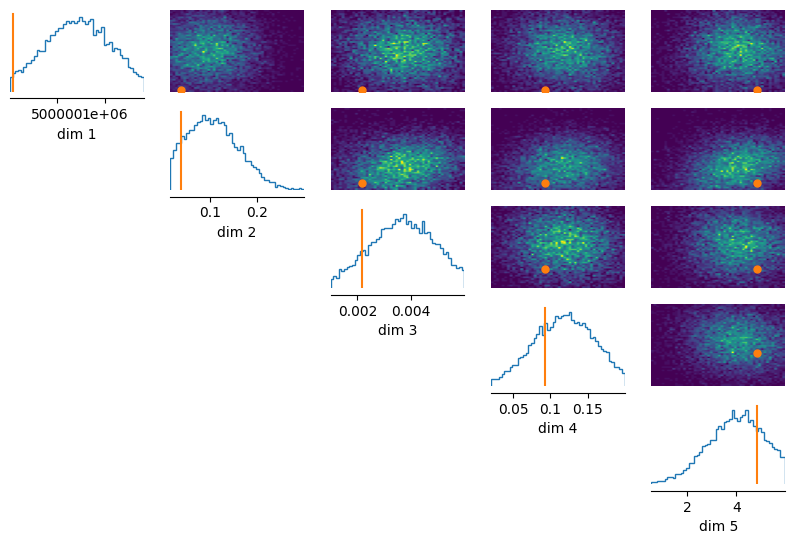

In [242]:
# Check the posterior
Simulator = ParallelSimulator(dt, DeltaT, TotalT, prior_limits, transient_time = transient, batch_size = 1)
x_test, _, _, thetas_test = Simulator.run(1)
RSVP_fit_test, _, _ = ComputeRSVP(x_test, TotalT, transient = transient)
RSVP_fit_test = torch.tensor(RSVP_fit_test).float()
samples = posterior.sample((10000,),x = RSVP_fit_test)
fig, ax = analysis.pairplot(samples, figsize=(10, 6), points=thetas_test.reshape(5,));

--------
# MultiRound Inference

In [3]:
# Set Up Parameters
dt = 1e-6
DeltaT = 1/25_000
TotalT = 10.
transient = 0.5
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

batch_size = 200
N = pathos.helpers.cpu_count()
TotalSim = batch_size * 16

In [4]:
def MultiRoundPipeline(dt,DeltaT,TotalT,prior_lims,transient,batch_size,N,n_rounds):
    Simulator = ParallelSimulator(dt, DeltaT, TotalT, prior_lims, transient_time = transient,batch_size = 1)
    x, y, f, thetas_exp = Simulator.run(1)
    RSVP_fit_exp,_,t = ComputeRSVP(x, TotalT)
    
    
    NumberOfParameters = len(prior_limits)
    BoxLimits = np.zeros((2, NumberOfParameters))
    i = 0
    for item in prior_limits.items():
        BoxLimits[0, i] = item[1][0]
        BoxLimits[1, i] = item[1][1]
        i +=1
    BoxLimits = torch.tensor(BoxLimits)
    prior = utils.BoxUniform(low=BoxLimits[0], high=BoxLimits[1])
    prior, _, _ = process_prior(prior)
    infer = SNPE(prior=prior)
    proposal = prior
    posteriors = []
    for _ in np.arange(n_rounds):
        print(f"\nRound: {_+1} / {n_rounds}")
        Simulator = ParallelSimulator(dt, DeltaT, TotalT, prior_lims, transient_time = transient,batch_size = batch_size, multi_round_mode=True, prior = proposal)
        x, y, f, thetas = Simulator.run(N)
        RSVP_fit, _, _ = ComputeRSVP(x, TotalT)
        RSVP_fit = torch.tensor(RSVP_fit).float()
        theta = torch.tensor(thetas).float().T.reshape(N*batch_size,5)
        density_estimator = infer.append_simulations(theta, RSVP_fit, proposal = proposal).train()
        posterior = infer.build_posterior(density_estimator)
        posterior = posterior.set_default_x(RSVP_fit_exp)
        posteriors.append(posterior)
        proposal = posterior
    return posteriors, thetas_exp

In [5]:
pos, thetas_exp = MultiRoundPipeline(dt,DeltaT,TotalT,prior_limits,transient,batch_size,N,2);

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

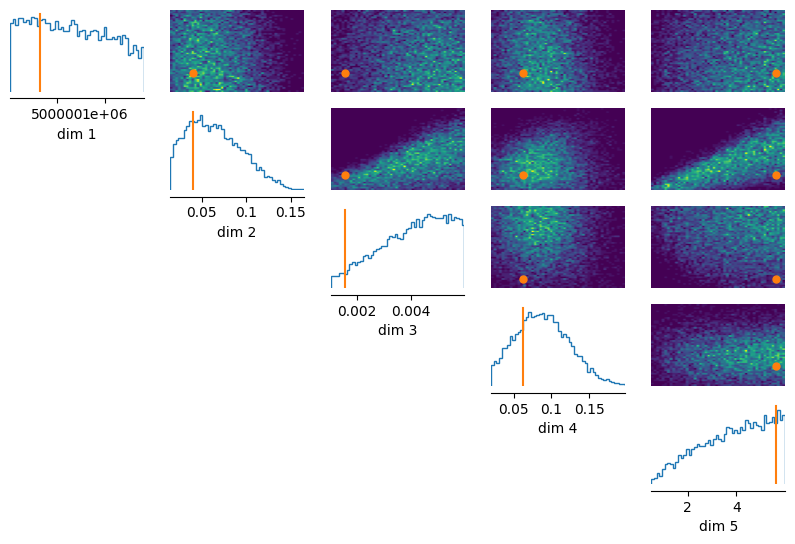

In [ ]:
last_posterior = pos[-1]
samples = last_posterior.sample((10000,))
fig, ax = analysis.pairplot(samples, figsize=(10, 6), points=thetas_exp.reshape(5,));

-------
# Test the Fit of SREDX

In [192]:
# RSVP Compute Function Declaration
def ComputeRSVP(multiple_raw_x_traces,TotalT,transient = 0.5,DeltaT = 1/25_000, function = None):
    t = np.linspace(transient, TotalT, multiple_raw_x_traces[0].shape[0])
    autocorr = stat_corr_single(multiple_raw_x_traces[0,:], 1) .reshape(1,-1)
    n_sim = multiple_raw_x_traces.shape[0]
    if n_sim != 1:
        for i in np.arange(1,n_sim):
            autocorr = np.vstack((autocorr, stat_corr_single(multiple_raw_x_traces[i,:], DeltaT)))
    
    t_corr = TotalT/10
    _,_,RSVP = stat_s_redx(autocorr[0], t_corr, t)
    if n_sim != 1:
        for i in np.arange(1,n_sim):
            _,_,RSVP_ = stat_s_redx(autocorr[i], t_corr, t)
            RSVP = np.vstack((RSVP, RSVP_))
        
    if function is None:
        def function(x, a, b, c, d):
            return 1e4*(a*np.exp(-b*x) + c/x + d)
    
    t = t[(t>0)*(t<t_corr)]
    
    RSVP_fit = np.zeros((n_sim, 4))
    
    if n_sim != 1:
        for i in np.arange(n_sim):
            popt, _ = curve_fit(function, t, RSVP[i], p0 = [1.,1.,1.,1.],maxfev=1000000, bounds=([-10,0,0,0],[10,np.inf,np.inf,np.inf]))
            RSVP_fit[i] = popt
    else:
        popt, _ = curve_fit(function, t, RSVP, p0 = [1.,1.,1.,1.],maxfev=1000000)
        RSVP_fit[0] = popt
        
    return RSVP_fit, RSVP, t

In [193]:
# Set up simulation parameters
dt = 1e-6
DeltaT = 1/25_000
TotalT = 10.
transient = 0.5
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}

batch_size = 50
N = pathos.helpers.cpu_count()
TotalSim = batch_size * N
t_sred = np.arange(transient, TotalT/20 + transient, DeltaT)

In [194]:
# Set up simulator and get sample theta
Simulator = ParallelSimulator(dt, DeltaT, TotalT, prior_limits, transient_time = 0.5, batch_size = batch_size)
prior = prior_from_lims(prior_limits)
theta = prior.sample((1,1)).T.reshape(5,1,1).numpy()
theta = np.repeat(theta, batch_size, axis = 1)

In [195]:
# Run Simulator
x,y,f = Simulator.same_theta_test(8,theta)

In [196]:
# Compute RSVP
def function(x, a, b, c, d):
    return 1e4*(a*np.exp(-b*x) + c/x + d)

RSVP_fit, RSVP, t_RSVP = ComputeRSVP(x, TotalT, function = function)

In [201]:
# Get Results
print(f"a: {np.mean(RSVP_fit[:,0]):.2E} ± {np.std(RSVP_fit[:,0]):.2E}")
print(f"b: {np.mean(RSVP_fit[:,1]):.3f} ± {np.std(RSVP_fit[:,1]):.4f}")
print(f"c: {np.mean(RSVP_fit[:,2]):.3f} ± {np.std(RSVP_fit[:,2]):.4f}")
print(f"d: {np.mean(RSVP_fit[:,3]):.3f} ± {np.std(RSVP_fit[:,3]):.4f}")

a: -9.55E-02 ± 3.72E-02
b: 2.489 ± 0.5801
c: 0.013 ± 0.0071
d: 0.002 ± 0.0057


In [198]:
def FitError(RSVP_fit,RSVP, function, t):
    for i in np.arange(RSVP_fit.shape[0]):
        if i == 0:
            y = function(t, *RSVP_fit[i])
        else:
            y = np.vstack((y, function(t, *RSVP_fit[i])))
    return np.sum(np.abs((y - RSVP)**2), axis = 1)

In [199]:
# Get Chi Squared
Errors = FitError(RSVP_fit,RSVP, function, t_RSVP)
print(f"Mean Chi Square: {np.mean(Errors):.2E} ± {np.std(Errors):.2E}")

Mean Chi Square: 6.12E+03 ± 6.34E+03
